In [1]:
import os
import glob
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats

In [2]:
def load_fits_images(dir: str, observation_date: str) -> tuple:
    """
    Carrega as imagens FITS de um diretório específico, excluindo imagens com nuvens.

    Parâmetros:
    dir (str): O diretório onde as imagens FITS estão armazenadas.
    observation_date (str): A data da observação para criar o caminho do diretório.

    Retorna:
    tuple: Uma tupla contendo:
        - image_names (list): Lista dos nomes das imagens carregadas.
        - images_data (list): Lista dos dados das imagens carregadas.
    """
    base_path = os.path.join(dir, f'{observation_date}/')
    file_pattern = os.path.join(base_path, '*.fit')
    fits_files = glob.glob(file_pattern)
    image_names = sorted([f for f in fits_files if not ('pg1530-021.fit' <= os.path.basename(f) <= 'pg1530-050.fit')])
    
    images_data = []
    for fits_file in image_names:
        hdu = fits.open(fits_file)
        images_data.append(hdu[0].data)
    
    return image_names, images_data

In [3]:
def calculate_photometry(dir: str, observation_date: str, stars_info: list[tuple], radius_aperture: float) -> tuple:
    """
    Calcula a fotometria de abertura para as imagens carregadas.

    Parâmetros:
    dir (str): O diretório onde as imagens FITS estão armazenadas.
    observation_date (str): A data da observação para a qual as imagens serão processadas.
    stars_info (list): Lista de informações (id, x_pos,y_pos,x_crop,y_crop, grau_rot) sobre as estrelas a serem analisadas, cada uma representada como uma tupla.
    radius_aperture (float): O raio da abertura circular a ser usada para a fotometria.

    Retorna:
    results (list): Uma lista de resultados, onde cada resultado é uma lista contendo:
        - image_name (str): Nome do arquivo da imagem.
        - image_data (np.ndarray): Dados da imagem.
        - annulus (CircularAnnulus): O objeto de anel circular utilizado para calcular o fundo.
        - dannulus (int): A largura do anel de fundo.
        - mag (float): A magnitude da estrela calculada.
        - MERR (float): O erro associado à magnitude.
    """

    image_names, images_data = load_fits_images(dir=dir, observation_date=observation_date)
    
    results = []
    for star_info, image_data, image_name in zip(stars_info, images_data, image_names):
        #print(image_name)
        _, x_star, y_star, row_slice, col_slice, _ = star_info

        # Obter a seção da imagem
        image_section = image_data[row_slice, col_slice]
        
        # Criar abertura
        aperture_cropped = CircularAperture((x_star, y_star), r=radius_aperture)
        radius_in = 15         # Raio interno do anel (igual ao IRAF)
        dannulus  = 5           # Largura do anel de fundo

        # Annulus
        annulus = CircularAnnulus((x_star, y_star), r_in=radius_in, r_out=radius_in + dannulus)
        
        # Fotometria de abertura
        photometry = aperture_photometry(image_section, aperture_cropped)

        # Contribuição do Céu
        bkg = ApertureStats(image_section, annulus)
        bkg_sum = bkg.sum
        bkg_mean = bkg.mean
        total_bkg = bkg_mean * aperture_cropped.area

        star_flux = photometry["aperture_sum"] - total_bkg
        FERR = np.sqrt(photometry['aperture_sum'][0]) + np.sqrt(bkg_sum)

        zmag = 25  # IRAF
        mag = zmag - 2.5 * np.log10(star_flux) if star_flux > 0 else np.inf

        if star_flux > 0:
            MERR = (1.0857 * FERR) / star_flux[0]
        else:
            MERR = np.inf  # Erro infinito se o fluxo total for zero

        results.append([image_name, image_data, annulus, dannulus, mag.item() if isinstance(mag, np.ndarray) else mag, float(MERR)])
    # Criar um DataFrame do pandas e salvar como CSV
    df = pd.DataFrame(results, columns=['image_name', 'image_data', 'annulus', 'dannulus', 'mag', 'MERR'])
    #df['image_name'] = [i.split('/')[2] for i in df['image_name']]
    df[['image_name', 'mag', 'MERR']].to_csv(f"{dir}/{observation_date}/results/photometry_results.csv", index=False)

    return results

In [4]:
def plot_images(dir,observation_date,stars_info,radius_aperture=13,radius_in: int = 15, rows: int = 4, columns: int = 5) -> None:
    """
    Plota as imagens com fotometria e anotações.

    Parâmetros:
    image_names (list): Lista dos nomes das imagens a serem plotadas.
    images_data (list): Lista dos dados das imagens a serem plotadas.
    observation_date (str): A data da observação, usada no título do gráfico.
    radius_aperture (float): O raio da abertura circular a ser usado para a fotometria.
    row_slice (slice, opcional): O intervalo de linhas a ser cortado da imagem. Default é slice(350, 700).
    col_slice (slice, opcional): O intervalo de colunas a ser cortado da imagem. Default é slice(450, 910).
    rows (int, opcional): O número de linhas para a exibição das imagens. Default é 4.
    columns (int, opcional): O número de colunas para a exibição das imagens. Default é 5.

    Retorna:
    None: A função apenas gera um gráfico e não retorna valores.
    """

    fig, axes = plt.subplots(rows, columns, figsize=(20, 10))
    fig.suptitle(f"{observation_date} PG1530+057A", fontsize=20, y=1)
    
    results = calculate_photometry(dir=dir, observation_date=observation_date, stars_info=stars_info , radius_aperture=radius_aperture)
    
    ims = []  # Para armazenar os objetos de imagem
    for i, (image_name, image_data, annulus, dannulus, mag, MERR) in enumerate(results):
        # Obter as coordenadas e o corte da estrela
        _, x_star, y_star, row_slice, col_slice, rotate_grau = stars_info[i]
        
        image_section = image_data[row_slice, col_slice]
        
        if rotate!=0:
            image_section = rotate(image_section, rotate_grau, reshape=False)    

        # Criar abertura
        aperture = CircularAperture((x_star, y_star), r=radius_aperture)

        # Annulus
        annulus = CircularAnnulus((x_star, y_star), r_in=radius_in, r_out=radius_in + dannulus)
        
        # Fotometria de abertura
        photometry = aperture_photometry(image_section, aperture)

        # Contribuição do Céu
        bkg       = ApertureStats(image_section, annulus)
        bkg_sum   = bkg.sum
        bkg_mean  = bkg.mean
        total_bkg = bkg_mean  * aperture.area

        star_flux = photometry["aperture_sum"] - total_bkg
        FERR = np.sqrt(photometry['aperture_sum'][0]) + np.sqrt(bkg_sum)

        zmag     = 25  # IRAF
        mag      = zmag -2.5*np.log10(star_flux) if star_flux > 0 else np.inf

        if star_flux > 0:
            MERR = (1.0857 * FERR) / star_flux[0]
        else:
            MERR = np.inf  # Erro infinito se o fluxo total for zero

        # Adicionar informações como labels na imagem
        textstr = '\n'.join((
            # f"TOTAL SUM: {photometry['aperture_sum'][0]:.3f}",
            # f"BKG SUM:   {bkg_sum:.3f}",
            # f"STAR FLUX: {star_flux.value[0]:.3f}",
            # f"FERR:      {FERR:.3f}",
            f"MAG:       {mag[0]:.3f}" if isinstance(mag, np.ndarray) else f"MAG:       {mag:.3f}",
            f"MERR:      {MERR:.3f}",
            # f"APERTURE:  {radius_aperture}",
            # f"ANNULUS:   {radius_in + dannulus}",
        ))

        
        #Imprimir os valores das variáveis
        # print("Image Name:", image_name)
        # print("Image Data Shape:", image_data.shape)
        # print("Annulus:", annulus)
        # print("Dannulus:", dannulus)
        # print("Magnitude (mag):", mags.item() if isinstance(mags, np.ndarray) else mags)
        # print("Magnitude Error (MERR):", float(MERRs))

        # Definindo limites de exibição
        vmin = np.percentile(image_section, 1)
        vmax = np.percentile(image_section, 99)

        ax = axes[i // columns, i % columns]
        im = ax.imshow(image_section, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
        ims.append(im)
        aperture.plot(color='red', lw=1.5, ax=ax, label='Aperture')
        annulus.plot(color='blue', lw=1.5, ax=ax, label='Annulus')        

        # Adicionar informações como labels na imagem
        textstr = '\n'.join((
            f"MAG:       {mag[0]:.3f}" if isinstance(mag, np.ndarray) else f"MAG:       {mag:.3f}",
            f"MERR:      {MERR:.3f}",
        ))         
        # Definir a posição do texto
        x_text = 0.05 * image_section.shape[1]
        y_text = 0.95 * image_section.shape[0]
        ax.text(x_text, y_text, textstr, fontsize=10, color='white', ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.2', edgecolor='white', facecolor='black', alpha=0.8))
        ax.set_title(image_name.split("/")[-1], fontsize=10, pad=10)

        # Plotar o anel
        annulus.plot(color='blue', lw=1.5, ax=ax, label='Annulus')

    # Criar uma única colorbar para todos os subplots na parte inferior
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    cbar = plt.colorbar(ims[0], cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=10)

    # Remover eixos de imagens não utilizadas, se houver
    for j in range(len(image_data), rows * columns):
        axes[j // columns, j % columns].axis('off')

    # Ajustar layout para evitar sobreposições
    plt.subplots_adjust(top=0.93, bottom=0.1, left=0.07, right=0.93, hspace=0.5, wspace=0.2)
    plt.savefig(f"{dir}{observation_date}/results/aperture_photometry")
    plt.show()

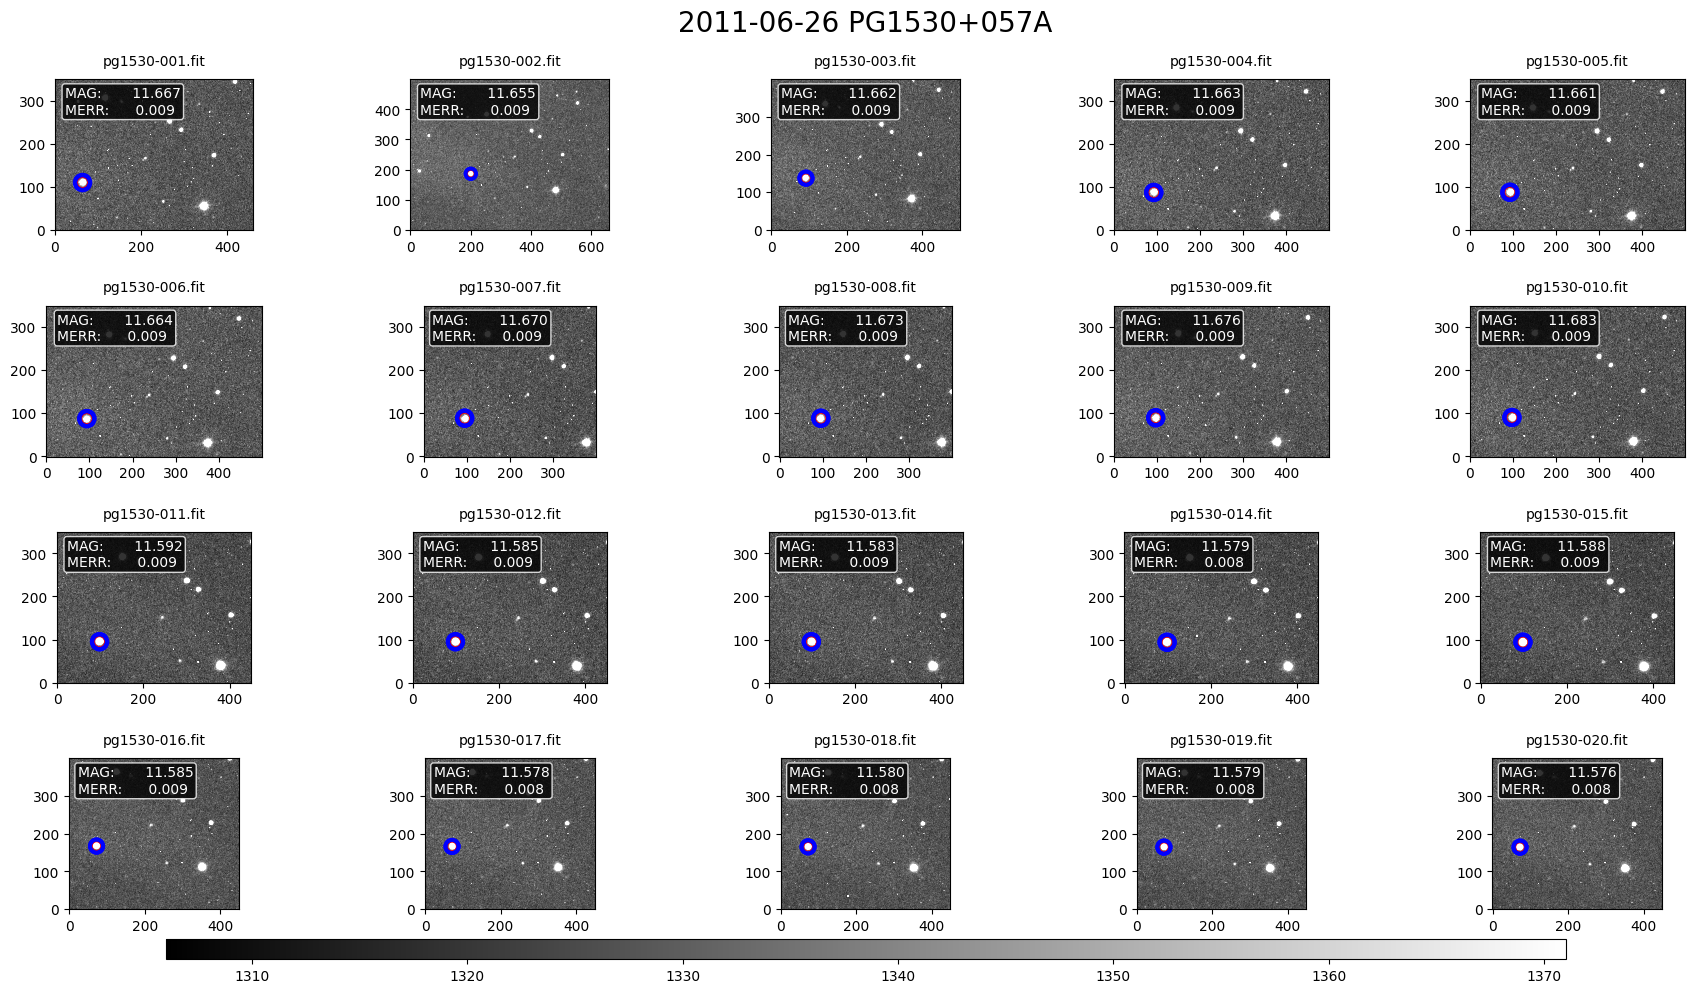

In [5]:
%matplotlib inline
dir = "observations/"
observation_date = "2011-06-26"
radius_aperture = 13
stars_info = [(0, 64,    110,     slice(350, 700),  slice(450, 910 ),     0),
            (1,  200.4,  186.4,   slice(250, 750),  slice(50,  710 ),   180),
            (2,  91.4,   137.4,   slice(300, 700),  slice(100, 600 ),  -180),
            (3,  92.5,   87,      slice(300,650 ),  slice(100, 600 ),  -180),
            (4,  93.20,  87.38,   slice(300,650 ),  slice(100, 600 ),  -180),
            (5,  94,     87.5,    slice(300,650 ),  slice(100, 600 ),  -180),
            (6,  95,     88.5,    slice(300,650 ),  slice(200, 600 ),  -180),
            (7,  95.7,   88.3,    slice(300,650 ),  slice(200, 600 ),  -180),
            (8,  97,     89.5,    slice(300,650 ),  slice(100, 600 ),  -180),
            (9,  97.8,   90.1,    slice(300,650 ),  slice(100, 600 ),  -180),
            (10, 98.5,   95.05,   slice(300,650 ),  slice(350, 800 ),  -180),
            (11, 98.6,   95.1,    slice(300,650 ),  slice(350, 800 ),  -180),
            (12, 98.6,   95,      slice(300,650 ),  slice(350, 800 ),  -180),
            (13, 98.4,   93.8,    slice(300,650 ),  slice(350, 800 ),  -180),
            (14, 98.3,   94,      slice(300,650 ),  slice(350, 800 ),   180),
            (15, 72.5,   167,     slice(300,700 ),  slice(250, 700 ),   0  ),
            (16, 71.5,   166,     slice(300,700 ),  slice(250, 700 ),   0  ),
            (17, 72,     165,     slice(300,700 ),  slice(250, 700 ),   0  ),
            (18, 72.,    164.2,   slice(300,700 ),  slice(250, 700 ),   0  ),
            (19, 72.6,   164.2,   slice(300,700 ),  slice(250, 700 ),   0  ),]

# Plota as imagens com a fotometria
plot_images(dir,observation_date,stars_info)